In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import argparse
import gudhi
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio

In [28]:
def format_labels(labels):
    formatted_labels = []
    for label in labels:
        parts = label.split('|')
        strain_name = parts[0].split('_')[0]  # Obtiene el nombre de la cepa
        epi_number = parts[1].split('_')[-1]  # Obtiene el número EPI
        formatted_label = f"{strain_name}_{epi_number}"
        formatted_labels.append(formatted_label)
    return formatted_labels

def count_strains(labels):
    strain_counts = {}
    strain_colors = {
        'BA.2': 'blue',
        'BA.2.10.1': 'orange',
        'BA.2.75': 'yellow',
        'XBB.1': 'green'
    }
    for label in labels:
        strain = label.split('_')[0]  # Obtiene el nombre de la cepa
        strain_counts[strain] = strain_counts.get(strain, 0) + 1
    print("Número de secuencias para la prueba:")
    for strain, count in strain_counts.items():
        color = strain_colors.get(strain, 'gray')
        print(f"{strain} = {count} ({color})")
    return strain_colors

In [29]:
def visualize_simplicial_complex(simplex_tree, filtration_value, vertex_names=None, save_filename=None, plot_size=1000, dpi=100):
    G = nx.Graph()
    tetrahedra = []

    for simplex, filt in simplex_tree.get_filtration():
        if filt <= filtration_value:
            if len(simplex) == 2:
                G.add_edge(simplex[0], simplex[1])
            elif len(simplex) == 1:
                G.add_node(simplex[0])
            elif len(simplex) == 3:
                G.add_edge(simplex[0], simplex[1])
                G.add_edge(simplex[1], simplex[2])
                G.add_edge(simplex[2], simplex[0])
            elif len(simplex) == 4:
                tetrahedra.append(simplex)

    pos = nx.spring_layout(G, dim=3)

    x_values, y_values, z_values = zip(*[pos[node] for node in G.nodes()])
    node_labels = [vertex_names[node] if vertex_names else str(node) for node in G.nodes()]
    
    # Assign colors based on strain
    strain_colors = count_strains(vertex_names)
    node_colors = [strain_colors.get(label.split('_')[0], 'gray') for label in node_labels]
    
    node_trace = go.Scatter3d(
        x=x_values, y=y_values, z=z_values,
        mode='markers',
        marker=dict(size=5, color=node_colors),
        hoverinfo='text',
        hovertext=node_labels
    )

    # Add 3D labels with improved visibility
    label_trace = go.Scatter3d(
        x=x_values, y=y_values, z=z_values,
        mode='text',
        text=node_labels,
        textposition="top center",
        textfont=dict(size=8, color='black', family='Arial Black'),  # Reduced size for better fit
        hoverinfo='none'
    )

    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(width=2, color='rgba(0,0,0,0.5)'),
        hoverinfo='none'
    )

    triangle_traces = []
    for simplex in simplex_tree.get_skeleton(2):
        if len(simplex[0]) == 3 and simplex[1] <= filtration_value:
            x = [pos[simplex[0][i]][0] for i in range(3)] + [pos[simplex[0][0]][0]]
            y = [pos[simplex[0][i]][1] for i in range(3)] + [pos[simplex[0][0]][1]]
            z = [pos[simplex[0][i]][2] for i in range(3)] + [pos[simplex[0][0]][2]]
            triangle_traces.append(go.Mesh3d(x=x, y=y, z=z, color='red', opacity=0.2))

    layout = go.Layout(
        showlegend=False,
        scene=dict(
            xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
            yaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
            zaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
        ),
        margin=dict(r=0, l=0, b=0, t=0)
    )

    fig = go.Figure(data=[edge_trace, node_trace, label_trace] + triangle_traces, layout=layout)
    
    fig.update_layout(width=plot_size, height=plot_size)

    if save_filename:
        pio.write_image(fig, save_filename, width=plot_size, height=plot_size, scale=1)

    fig.show()

    return G


In [30]:
#Lee el archivo FASTA y manda los nombres y secuencias a un diccionario
with open('nextclade.aligned.fasta') as f:
  sequences = {} #inicializa el diccionario
  name = None
  for line in f:
    line = line.strip()
    if line.startswith('>'):  
      name = line[1:]
      sequences[name] = ''
    else:
      sequences[name] += line

In [31]:
#Imprime los nombres de las secuencias encontradas.
print("Secuencias:")
i = 0
for name in sequences.keys():
  print(str(i)+' '+name)
  i=i+1

Secuencias:
0 BA.2.10.1_hCoV-19/Mexico/QUE-LANGEBIO_IMSS_14092/2023|EPI_ISL_16968470|2023-01-13
1 BA.2.75.2_hCoV-19/Mexico/CMX_IBT_IMSS_9908/2022|EPI_ISL_15671212|2022-10-07
2 BA.2.10.1_hCoV-19/Mexico/HID-INMEGEN-70-132/2022|EPI_ISL_12666024|2022-05-01
3 BA.2.75.2_hCoV-19/Mexico/CMX-INMEGEN-95-310/2022|EPI_ISL_16278985|2022-12-12
4 BA.2.75.2_hCoV-19/Mexico/MEX-INMEGEN-92x-18/2022|EPI_ISL_15608996|2022-09-25
5 BA.2_hCoV-19/Mexico/BCN_CIAD-IMSS_202201050913/2022|EPI_ISL_12533151|2022-04-19
6 BA.2_hCoV-19/Mexico/MEX_InDRE_FB13911_E_S13150/2022|EPI_ISL_12739324|2022-04-16
7 BA.2_hCoV-19/Mexico/SIN_CIAD-MZT_HJ6105/2022|EPI_ISL_13368395|2022-05-25
8 XBB.1_hCoV-19/Mexico/TAM_LANGEBIO_IMSS_13849/2022|EPI_ISL_16861713|2022-12-19
9 XBB.1_hCoV-19/Mexico/TAM_LANGEBIO_IMSS_13854/2022|EPI_ISL_16861711|2022-12-19
10 XBB.1_hCoV-19/Mexico/VER-LANGEBIO_IMSS_13979/2023|EPI_ISL_16968355|2023-01-23


In [32]:
num_seqs = len(sequences)
dist_matrix = np.zeros((num_seqs, num_seqs))

for i in range(num_seqs):
    for j in range(i+1, num_seqs):
        # Usamos list(sequences.items()) para convertir el diccionario a una lista de tuplas (nombre, secuencia)
        name1, seq1 = list(sequences.items())[i]
        name2, seq2 = list(sequences.items())[j]
        diff_count = 0
        
        # Modificamos el rango para excluir los primeros 54 y los últimos 68 caracteres
        for k in range(0, len(seq1)):
            # Para cada par de secuencias, cuenta el número de diferencias (mutaciones) entre ellas en los rangos especificados.
            if seq1[k] != seq2[k] and seq1[k] != 'N' and seq2[k] != 'N':
                diff_count += 1
        
        # Guarda las distancias en la matriz de distancia simétrica
        dist_matrix[i,j] = diff_count
        dist_matrix[j,i] = diff_count

print(dist_matrix)

[[  0.  74. 110.  92. 125.  75.  76.  90.  30.  27.  31.]
 [ 74.   0.  89.  39.  73.  64.  73.  69.  72.  51.  63.]
 [110.  89.   0.  74.  50.  51.  58.  52. 129. 106. 120.]
 [ 92.  39.  74.   0.  58.  57.  66.  54. 104.  81.  95.]
 [125.  73.  50.  58.   0.  77.  86.  78. 138. 115. 129.]
 [ 75.  64.  51.  57.  77.   0.  16.  43.  95.  72.  86.]
 [ 76.  73.  58.  66.  86.  16.   0.  51.  96.  73.  87.]
 [ 90.  69.  52.  54.  78.  43.  51.   0. 111.  88. 102.]
 [ 30.  72. 129. 104. 138.  95.  96. 111.   0.   5.   5.]
 [ 27.  51. 106.  81. 115.  72.  73.  88.   5.   0.   6.]
 [ 31.  63. 120.  95. 129.  86.  87. 102.   5.   6.   0.]]


In [33]:
pd.DataFrame(dist_matrix).shape

(11, 11)

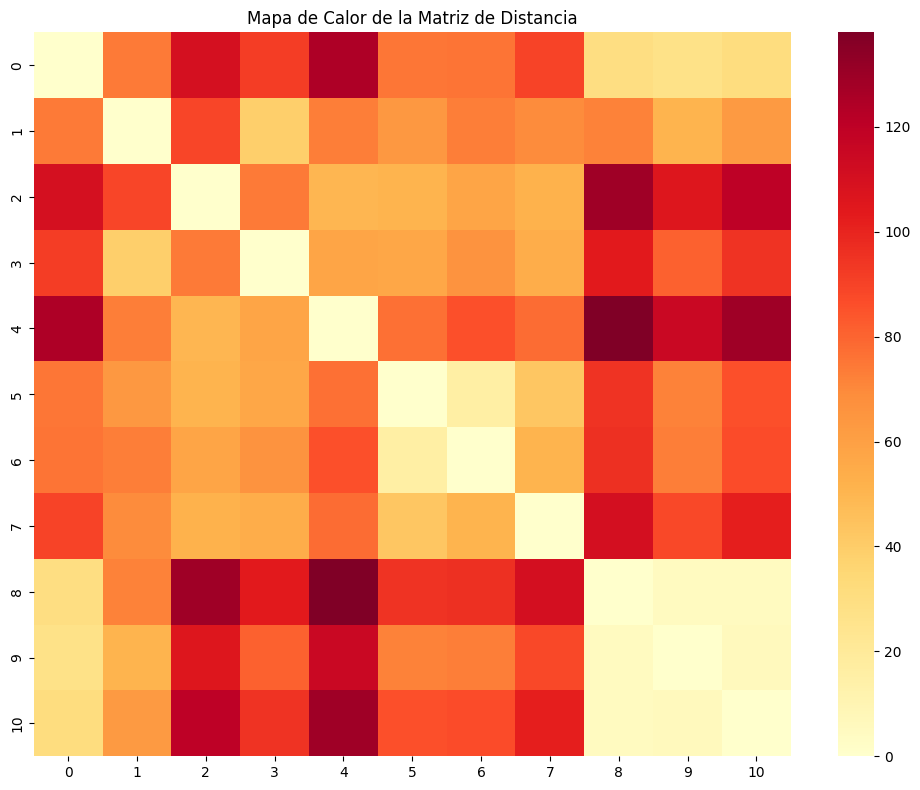

In [34]:
import seaborn as sns
# Crear la figura y los ejes
plt.figure(figsize=(10, 8))

# Generar el mapa de calor
sns.heatmap(dist_matrix, annot=False, cmap='YlOrRd')

# Añadir título
plt.title('Mapa de Calor de la Matriz de Distancia')

# Ajustar el diseño
plt.tight_layout()


In [35]:
max_edge_length = 1000
max_dimension = 3
band = 0.0

print("#####################################################################")
print("RipsComplex creation from defined distance matrix G3")
   
rips_complex = gudhi.RipsComplex(
   distance_matrix=dist_matrix, max_edge_length=max_edge_length  
)

#####################################################################
RipsComplex creation from defined distance matrix G3


In [36]:
simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
   
message = "Number of simplices=" + repr(simplex_tree.num_simplices()) 
print(message)
  
diag = simplex_tree.persistence()

print("betti_numbers()=")
print(simplex_tree.betti_numbers())

# Add this new code to print birth and death times for 1D and 2D holes
print("\nPersistence intervals for 1-dimensional holes:")
for interval in simplex_tree.persistence_intervals_in_dimension(1):
    print(f"Birth: {interval[0]}, Death: {interval[1]}")

print("\nPersistence intervals for 2-dimensional holes:")
for interval in simplex_tree.persistence_intervals_in_dimension(2):
    print(f"Birth: {interval[0]}, Death: {interval[1]}")

Number of simplices=561
betti_numbers()=
[1, 0, 0]

Persistence intervals for 1-dimensional holes:
Birth: 58.0, Death: 74.0

Persistence intervals for 2-dimensional holes:


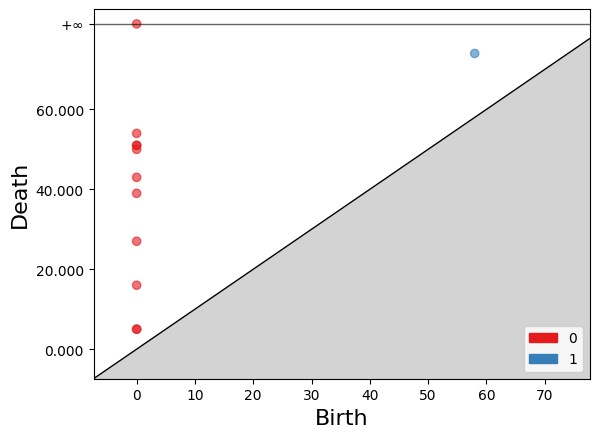

In [37]:
gudhi.plot_persistence_diagram(diag, band=band)
plt.title("")
plt.show()

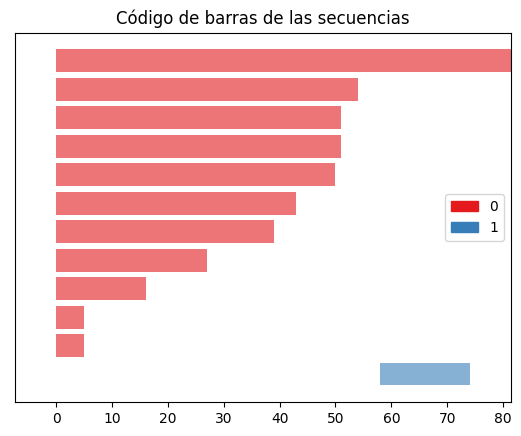

In [38]:
gudhi.plot_persistence_barcode(diag)
plt.title("Código de barras de las secuencias")
plt.show()

Visualizing 3D simplicial complex at filtration time 58
Número de secuencias para la prueba:
BA.2.10.1 = 2 (orange)
BA.2.75.2 = 3 (gray)
BA.2 = 3 (blue)
XBB.1 = 3 (green)


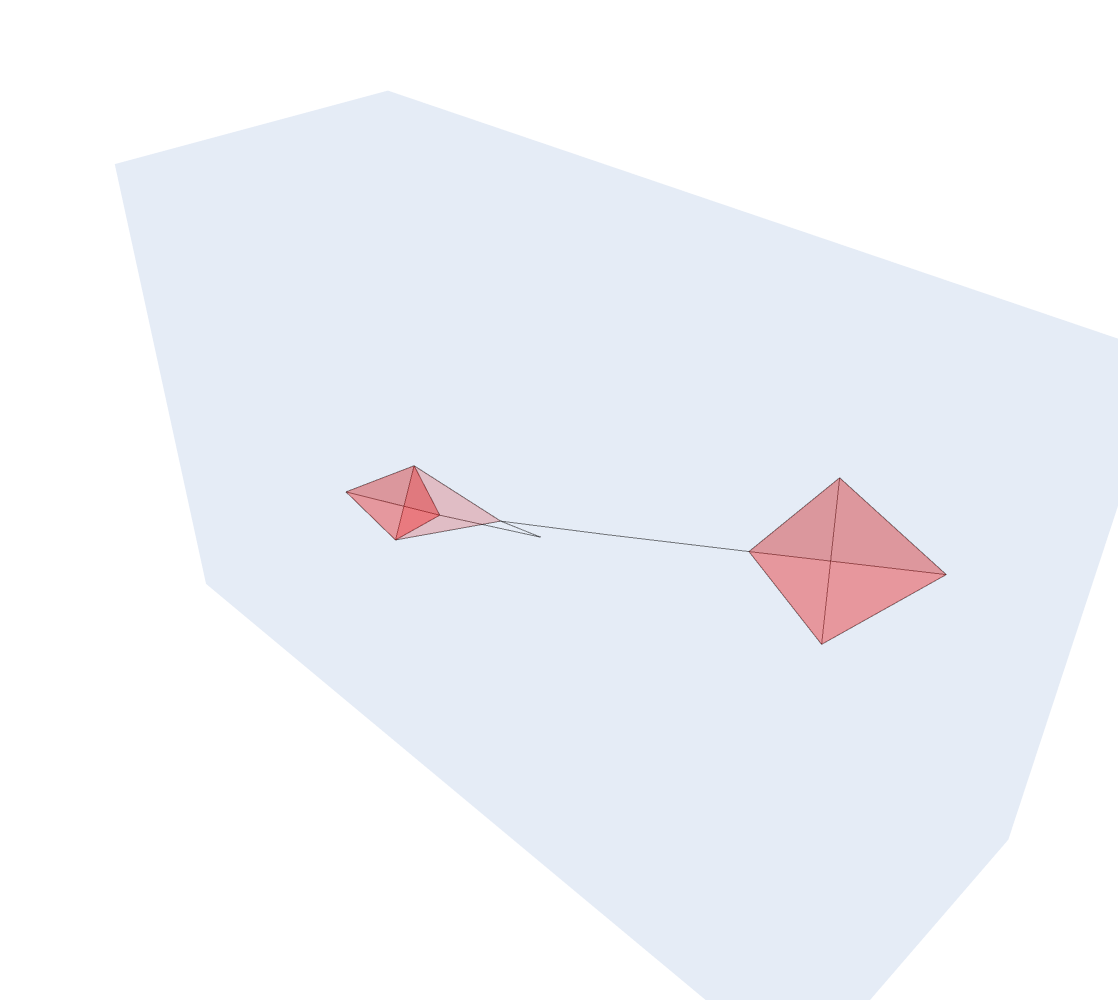

In [39]:
labels = [
    "BA.2.10.1_hCoV-19/Mexico/QUE-LANGEBIO_IMSS_14092/2023|EPI_ISL_16968470|2023-01-13",
    "BA.2.75.2_hCoV-19/Mexico/CMX_IBT_IMSS_9908/2022|EPI_ISL_15671212|2022-10-07",
    "BA.2.10.1_hCoV-19/Mexico/HID-INMEGEN-70-132/2022|EPI_ISL_12666024|2022-05-01",
    "BA.2.75.2_hCoV-19/Mexico/CMX-INMEGEN-95-310/2022|EPI_ISL_16278985|2022-12-12",
    "BA.2.75.2_hCoV-19/Mexico/MEX-INMEGEN-92x-18/2022|EPI_ISL_15608996|2022-09-25",
    "BA.2_hCoV-19/Mexico/BCN_CIAD-IMSS_202201050913/2022|EPI_ISL_12533151|2022-04-19",
    "BA.2_hCoV-19/Mexico/MEX_InDRE_FB13911_E_S13150/2022|EPI_ISL_12739324|2022-04-16",
    "BA.2_hCoV-19/Mexico/SIN_CIAD-MZT_HJ6105/2022|EPI_ISL_13368395|2022-05-25",
    "XBB.1_hCoV-19/Mexico/TAM_LANGEBIO_IMSS_13849/2022|EPI_ISL_16861713|2022-12-19",
    "XBB.1_hCoV-19/Mexico/TAM_LANGEBIO_IMSS_13854/2022|EPI_ISL_16861711|2022-12-19",
    "XBB.1_hCoV-19/Mexico/VER-LANGEBIO_IMSS_13979/2023|EPI_ISL_16968355|2023-01-23"
]
print("Visualizing 3D simplicial complex at filtration time 58")
visualize_simplicial_complex(simplex_tree, 58, vertex_names=format_labels(labels))